These are systems with a contact Hamiltonian of the form
$$
H = ps + f(q)s + F(q, t)
$$

We will focus in particular on the Van der Pol oscillator
where $f(q) = - \epsilon (1-q^2)$ and $F(q) = q - \phi(t)$.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
from integrators import contact as ic
from integrators.common import rk4

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def D(system, dt,p,q,s,t):
    t += dt
    return p,q,s,t

def C(system, dt,p,q,s,t):
    q += s*dt
    p /= 1. + p*dt
    return p,q,s,t 

def B(system, dt,p,q,s,t):
    p -= system.Vq(q, t)*dt
    s -= system.V(q, t)*dt
    return p,q,s,t

def A(system, dt,p,q,s,t):
    f_q = system.f(q)
    if np.abs(f_q) < np.finfo(float).eps:
        p -= system.fq(q)*s*dt
        # s=s
    else:
        ex = np.exp(-dt*f_q)
        p = (p + system.fq(q)*s/f_q)*ex
        s *= ex
    return p,q,s,t
    
def step1(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (C,0.5), (B,0.5), (A,1), (B,0.5), (C,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step2(system, dt, p, q, s, t):
    for ap,coeff in [(D,0.5), (A,0.5), (B,0.5), (C,1), (B,0.5), (A,0.5), (D,0.5)]:
        p, q, s, t = ap(system, dt*coeff,p,q,s,t)
    return p, q, s, t

def step6(system, dt, p, q, s, t, a=ic.a_six, stepper=step1):
    return ic.step6(system, dt, p, q, s, t, a=a, stepper=stepper)

In [8]:
class Lienard:
    def __init__(self, f, fq, F, Fq):
        self.f = f
        self.fq = fq
        self.F = F
        self.Fq = Fq
    
    def f(self, q):
        return self.f(q)
    
    def fq(self, q):
        return self.fq(q)
    
    def V(self, q, t):
        return self.F(q, t)
    
    def Vq(self, q, t):
        return self.Fq(q, t)

In [9]:
def vanDerPol(epsilon, a, omega):
    
    def f(q):
        return -epsilon*(1 - q**2)
    def fq(q):
        return 2*epsilon*q
    def F(q, t):
        return q - a*np.cos(omega*t)
    def Fq(q, t):
        return 1
    
    return Lienard(f, fq, F, Fq)

## Orbits $\epsilon = 0$

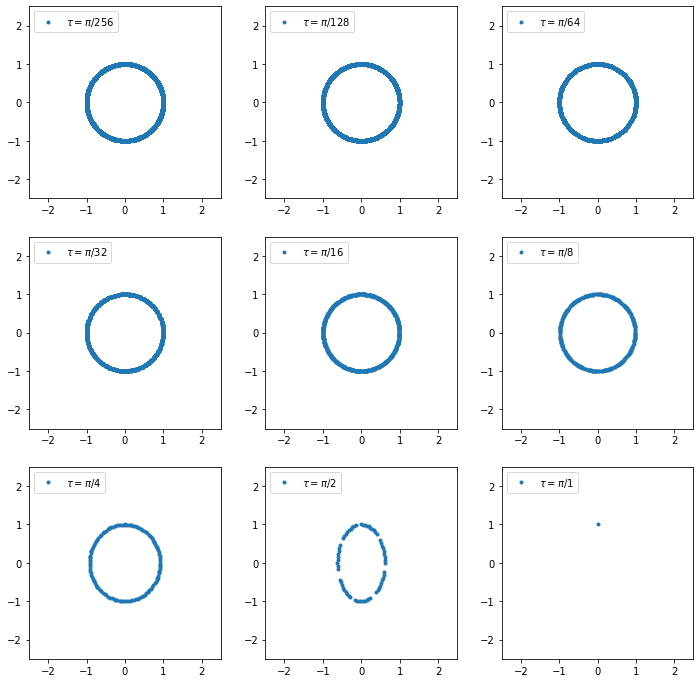

In [7]:
tf = 10000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))
for fact, spl in [(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]:
    tspan = np.arange(0, tf, np.pi/fact)
    plt.subplot(spl)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,
             '.',label=r"$\tau = \pi $/" f"${fact}$")
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xlim((-2.5,2.5))
    plt.ylim((-2.5,2.5))
    plt.legend(loc='upper left')

plt.show()

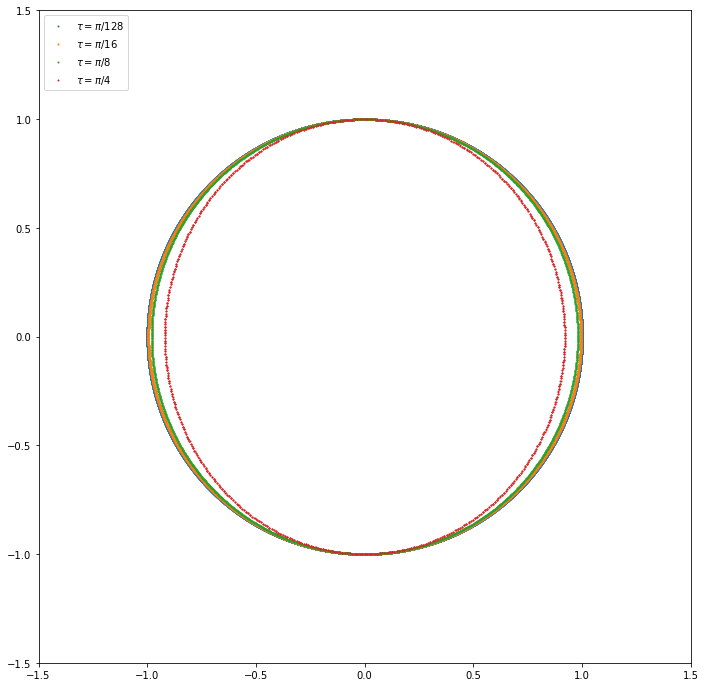

In [8]:
tf = 1000
p0, q0, s0 = 0, 0., 1.
epsilon = 0
vdp = vanDerPol(epsilon, 0, 0)
plt.figure(figsize=(12,12))

for fact in [128,16,8,4]:
    tspan = np.arange(0, tf, np.pi/fact)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    plt.plot(sol[:,1],sols,'.',
             label=r"$\tau = \pi $/" f"${fact}$",
             markersize=2)
    
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim((-1.5,1.5))
plt.ylim((-1.5,1.5))
plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon=0$

In [ ]:
#we have to fix the function of the Modified Hamiltonian as O(tau^8)
#and also insert a comparison with the different choice of the modified Hamiltonian.

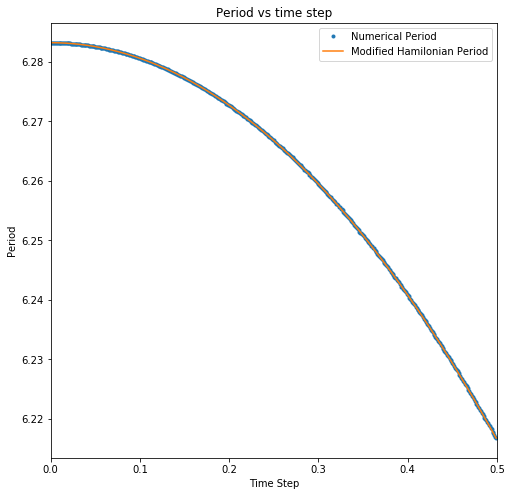

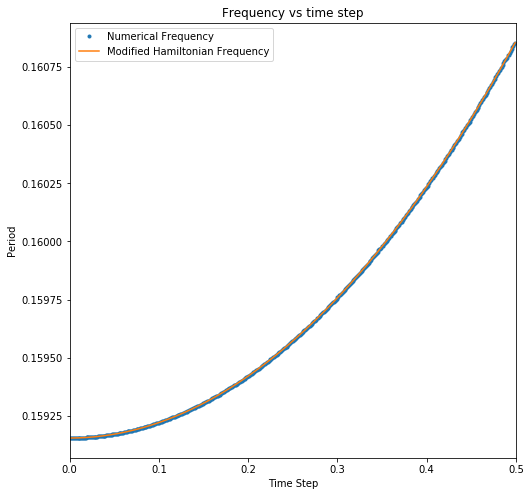

In [11]:
#Long integration with tf tf=20000
#to have a result in a human time fix tf = 200
tf = 20000
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0]
dt=np.arange(0.001,0.5,0.001)

T=np.zeros(len(dt))


for factor in range(len(dt)):
    t=np.zeros(int(tf))
    tspan = np.arange(0, tf, dt[factor])
    vdp = vanDerPol(0, 0, 0)
    sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
    maxi=np.zeros(int(tf/np.pi))
    ns=int(tf/dt[factor])-1
    j=0
    #computation of periods
    for i in range(ns):
        if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
            #sols[i] is a local nmaximum for s
            maxi[j]=tspan[i]
            j+=1
    for i in range(1,j-1):
        t[i]=(maxi[i+1]-maxi[i])
        T[factor]+=t[i]
    T[factor]=T[factor]/(j-2)
    #j-2 since avoid the first and the last orbit

    
T[T != 0]

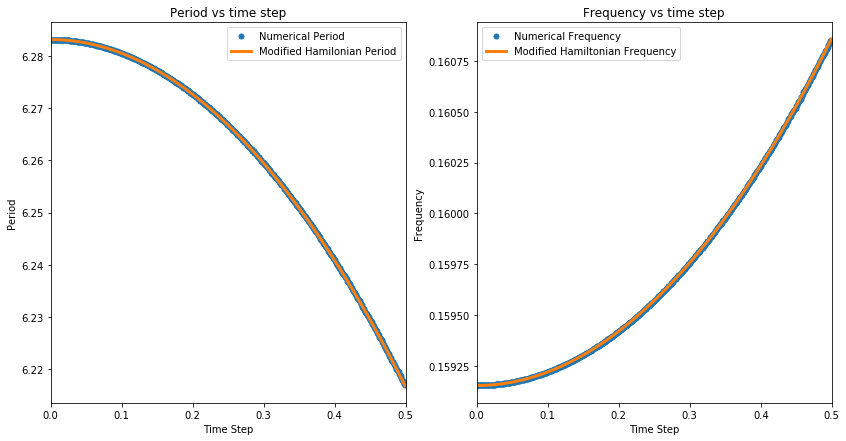

In [25]:
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period",markersize=10)
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi)),
         label="Modified Hamilonian Period",linewidth=3)
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency",markersize=10)
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi),
        label="Modified Hamiltonian Frequency",linewidth=3)
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

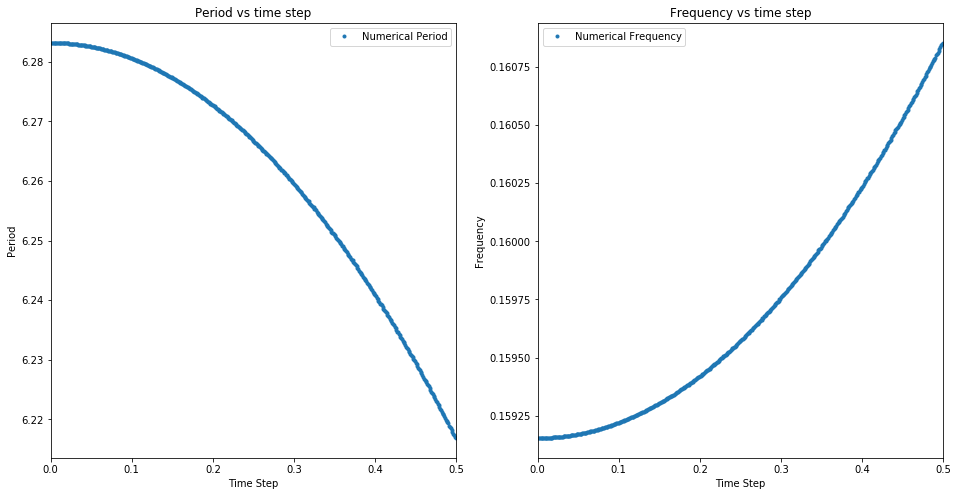

In [16]:
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.gca().set_title("Period vs time step")
plt.plot(dt,T,'.',label="Numerical Period")
plt.xlim((0,0.5))
plt.ylabel("Period")
plt.xlabel("Time Step")
plt.legend(loc='bottom left')

plt.subplot(122)
plt.gca().set_title("Frequency vs time step")
plt.plot(dt,1/T,'.',label="Numerical Frequency")
plt.xlim((0,0.5))
plt.ylabel("Frequency")
plt.xlabel("Time Step")
plt.legend(loc='upper left')
plt.show()

## Orbits $\epsilon \sim 1$

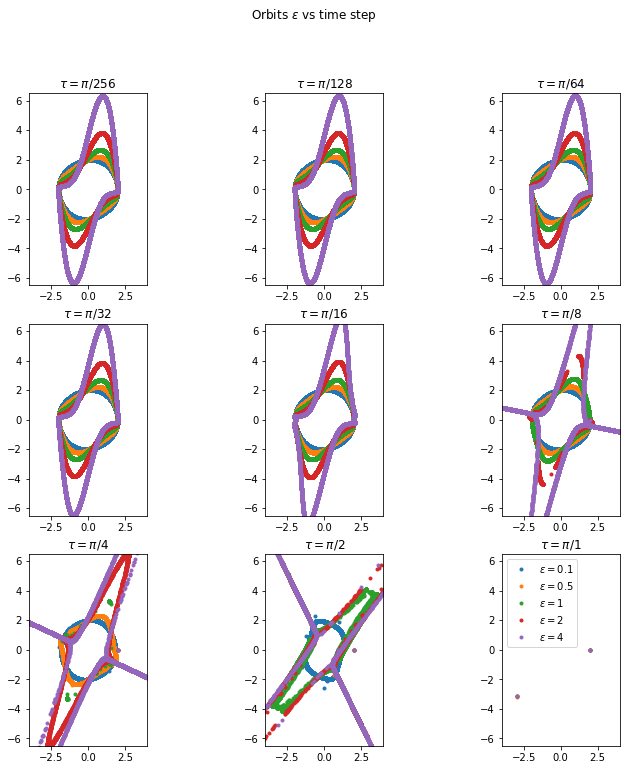

In [13]:
tf = 10000
p0, q0, s0 = 0, 2, 0
plt.figure(figsize=(12,12))
elist=[0.1,0.5,1,2,4]
plt.suptitle(r"Orbits $\epsilon$ vs time step")
steps=[(256,"331"),(128,"332"),(64,"333"),
                (32,"334"),(16,"335"),(8,"336"),
                (4,"337"),(2,"338"),(1,"339")]
for fact, spl in steps:
    for epsilon in elist:
        vdp = vanDerPol(epsilon, 0, 0)
        tspan = np.arange(0, tf, np.pi/fact)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = \pi /" f"${fact}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sols,'.',
                 label=r"$\epsilon = $" f"${epsilon}$")
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlim((-4,4))
        plt.ylim((-6.5,6.5))


plt.legend(loc='upper left')
plt.show()

## Period and frequency vs time step $\epsilon\sim1$ NOT ENDED!

In [ ]:
tf = 20000
tau=0.4
# p0, q0, s0 = 0.0, 1.0, 1.5
p0, q0, s0 = 0.0, 2.0, 0
elist=[0.1,0.5,1,2,4]
dt=np.arange(0.001,0.5,0.001)

T=np.zeros((len(dt),len(elist)))

k=-1

for epsilon in elist:
    k+=1
    for factor in range(len(dt)):
        t=np.zeros(int(tf))
        tspan = np.arange(0, tf, dt[factor])
        vdp = vanDerPol(epsilon, 0, 0)
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        maxi=np.zeros(int(tf/np.pi))
        ns=int(tf/dt[factor])-1
        j=0
        for i in range(ns):
            if (sols[i-1]<sols[i] and sols[i]>sols[i+1]):
                maxi[j]=tspan[i]
                j+=1
        for i in range(1,j-1):
            t[i]=(maxi[i+1]-maxi[i])
            T[factor,k]+=t[i]
        T[factor,k]=T[factor,k]/(j-2)

    
T[T != 0]
plt.figure(figsize=(8,8))
plt.plot(dt,1/(np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                       (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi)))
plt.plot(dt,T,'.')
plt.xlim((0,0.5))
plt.show()

plt.figure(figsize=(8,8))
plt.plot(dt,np.sqrt((5040 - 420*dt**2 - 42*dt**4 - 6*dt**6 - dt**8)*
                    (1260 + 210*dt**2 + 42*dt**4 + 9*dt**6 + 2*dt**8))/(5040.*np.pi))
plt.plot(dt,1/T,'.')
plt.xlim((0,0.5))
plt.show()

## Orbits for $\epsilon \gg 1$

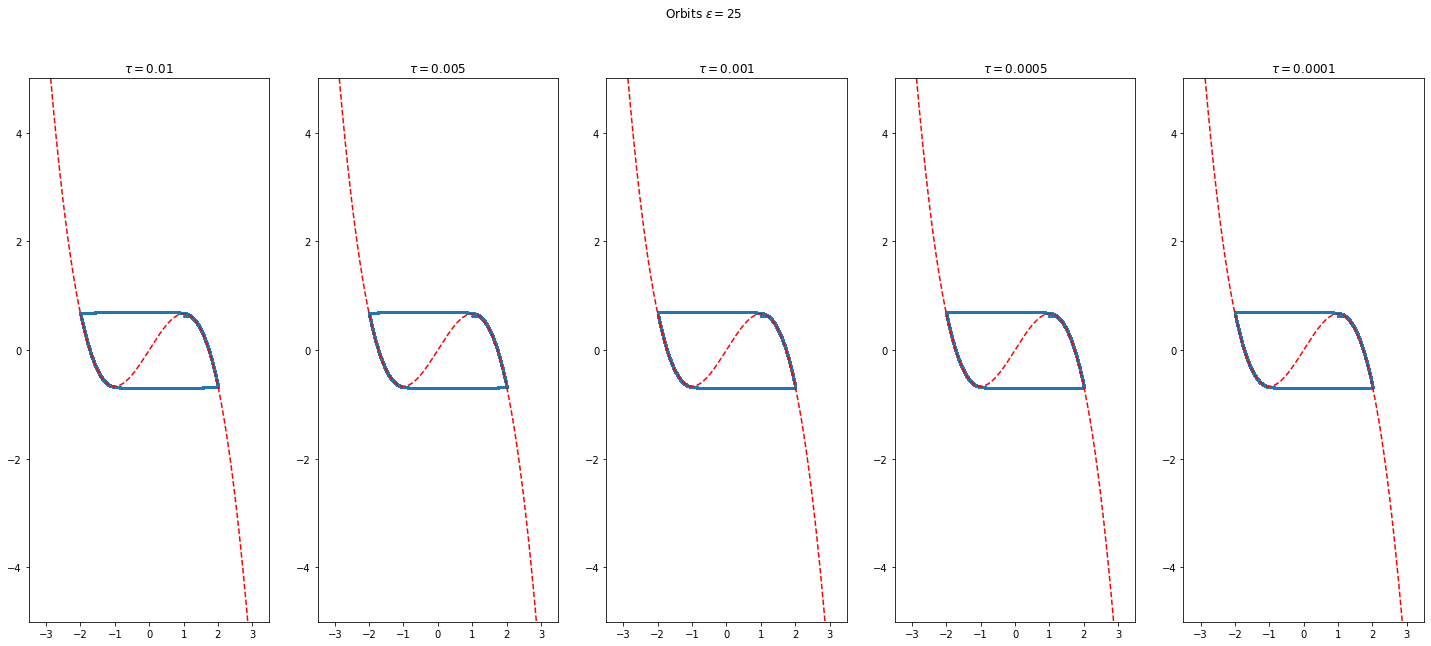

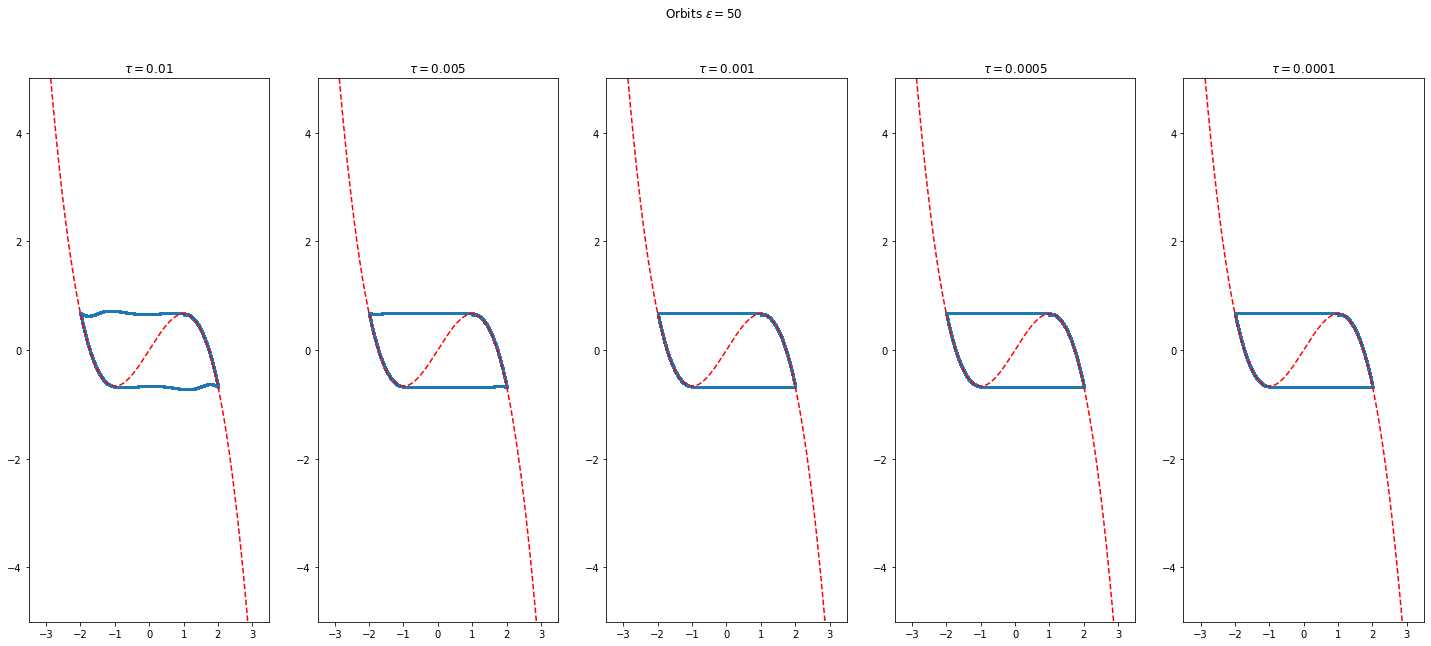

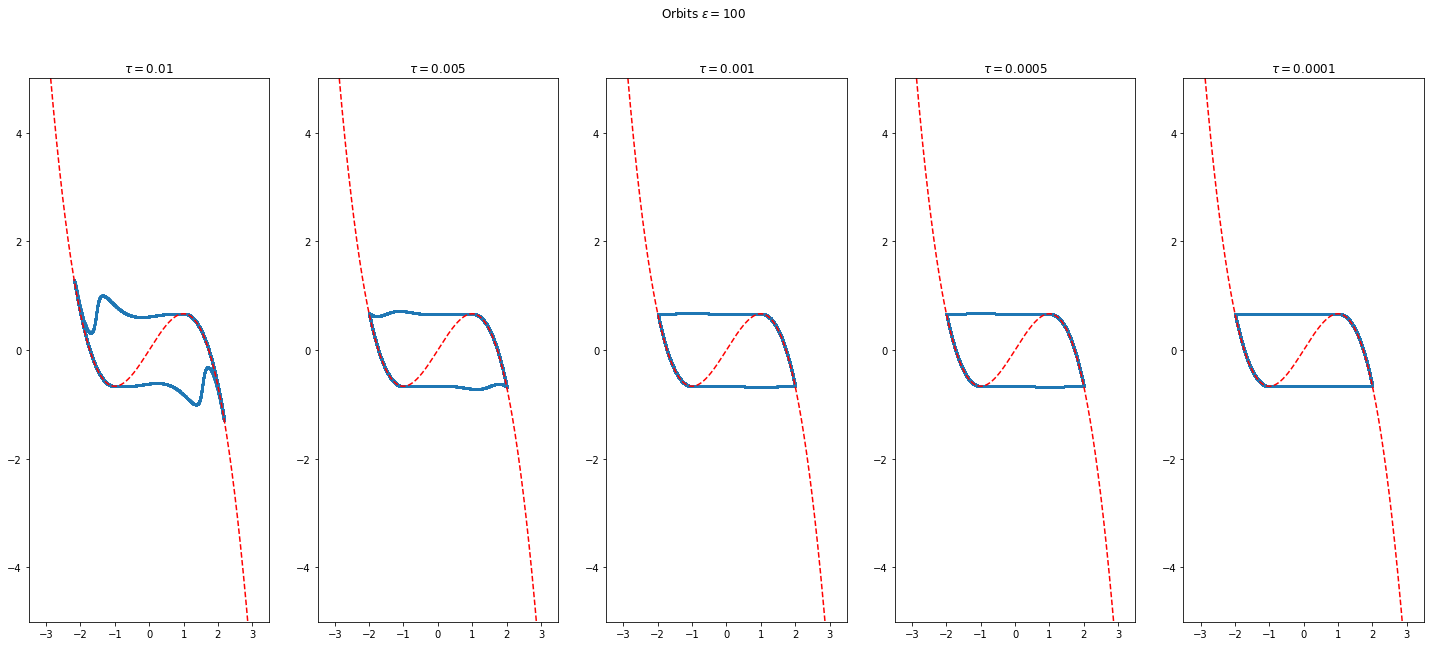

In [13]:
tf = 10000
p0, q0, s0 = -1., 1., 1.
elist=[25,50,100]
x=np.arange(-3.5,3.5,0.01)
for epsilon in elist:
    vdp = vanDerPol(epsilon, 0, 0)
    plt.figure(figsize=(25,10))
    plt.suptitle(r"Orbits $\epsilon =$" f"{epsilon}")
    for dt, spl in [(0.01,"151"),(0.005,"152"),(0.001,"153"),(0.0005,"154"),(0.0001,"155")]: 
        tspan = np.arange(0, dt*10**7, dt)
        plt.subplot(spl)
        plt.gca().set_title(r"$\tau = " f"${dt}")
        sol, sols, _ = ic.integrate(step1, vdp, tspan, p0, q0, s0)
        plt.plot(sol[:,1],sol[:,1]-(sol[:,1])**3 /3 - (sols/epsilon),
                 '.',markersize=3)
        plt.plot(x, x-(1/3)*(x)**3,'r--')
        plt.xlim((-3.5,3.5))
        plt.ylim((-5,5))
    plt.show()